In [417]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np

In [418]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [419]:
# Расчет прироста
def gain(left_labels, right_labels, root_criterion, criterion):
    
    # доля выборки, ушедшая влево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [420]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [421]:
def regress_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return regress_object(obj, node.true_branch)
    else:
        return regress_object(obj, node.false_branch)

In [422]:
def predict(data, tree):
    
    preds = []
    for obj in data:
        prediction = regress_object(obj, tree)
        preds.append(prediction)
    return preds

In [423]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [424]:
data, targets = datasets.make_regression(n_features=2, n_informative=2, random_state=11)

In [425]:
train_data, test_data, train_target, test_target = train_test_split(data, targets, test_size=0.3, random_state=11)

In [426]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        prediction = self.targets.mean()
        return prediction 

In [427]:
def dispersion(targets):
    return np.mean((targets - targets.mean())**2)

In [428]:
def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    root_mse = dispersion(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    for index in range(n_features):
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_gain = gain(true_targets, false_targets, root_mse, dispersion)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [429]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    quality, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)
    node = Node(index, t, true_branch, false_branch)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [430]:
my_tree = build_tree(train_data, train_target)
print_tree(my_tree)

Индекс 1 <= -0.10514925319146644
--> True:
  Индекс 0 <= -0.6473026312724075
  --> True:
    Прогноз: -135.5100476386366
  --> False:
    Индекс 1 <= -0.7054140258656812
    --> True:
      Индекс 1 <= -1.1398056522390698
      --> True:
        Прогноз: -52.22440528237551
      --> False:
        Прогноз: -65.11694204144327
    --> False:
      Индекс 0 <= 0.3154026684256969
      --> True:
        Индекс 0 <= -0.13290989911115147
        --> True:
          Прогноз: -40.23364204450606
        --> False:
          Прогноз: -12.022212487575015
      --> False:
        Прогноз: 26.034207414811114
--> False:
  Индекс 0 <= 0.370506334286746
  --> True:
    Индекс 0 <= -0.31963136376429824
    --> True:
      Индекс 1 <= 0.6873123485844095
      --> True:
        Прогноз: -33.988329460639775
      --> False:
        Прогноз: 20.27719125385306
    --> False:
      Индекс 1 <= 0.5165523855469867
      --> True:
        Прогноз: 26.076294629926487
      --> False:
        Прогноз: 70.09118838

In [431]:
train_answers = predict(train_data, my_tree)
train_r2 = r2_score(train_target, train_answers)
print(f'Train r2:\t{train_r2:.2f}')

test_answers = predict(test_data, my_tree)
test_r2 = r2_score(test_target, test_answers)
print(f'Test r2:\t{test_r2:.2f}')

Train r2:	0.91
Test r2:	0.85


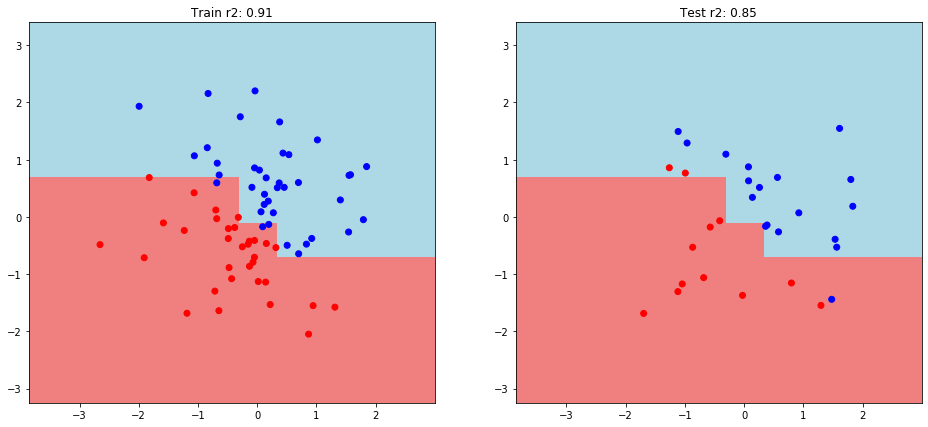

In [432]:
# Визуализируем дерево на графике
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_target, cmap = colors)
plt.title(f'Train r2: {train_r2:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_target, cmap = colors)
plt.title(f'Test r2: {test_r2:.2f}')

plt.show()